# On Mahalanobis distance in functional settings
Work by Berrendero, et.al. ([link](https://arxiv.org/abs/1803.06550))

The main idea:
> Given two functions $x, m \in L^2[0,1]$, just approximate them by two other functions $x_\alpha, m_\alpha \in \mathcal{H}(K)$ and calculate the distance $\vert\vert x_\alpha - m_\alpha\vert\vert_K$.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy import stats

/Users/gerardoduran/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## The $\alpha$-Mahalanobis distance

$$
    x_\alpha = (\mathcal K + \alpha \mathbb{I})^{-1} \mathcal K x = \sum_{j=1}^\infty \frac{\lambda_j}{\alpha + \lambda_j} \langle x, e_j \rangle_2 e_j
$$


The functional Mahalanobis distance is given by
$$
    M_\alpha(x, m)^2 = \sum_{j=1}^\infty \frac{\lambda_j}{(\lambda_j + \alpha)^2}\langle x - m, e_j \rangle_2^2
$$

In [3]:
def sample_brownian_motion(key, T, N, n_samples=1):
    dwt = jax.random.normal(key, (n_samples, N)) / jnp.sqrt(N)
    wt = dwt.cumsum(axis=1)
    return wt
    
def sample_brownian_bridge(key, T, N, n_samples=1):
    timesteps = jnp.linspace(0, T, N)
    wt = sample_brownian_motion(key, T, N, n_samples)
    wt_bridge = wt - jnp.einsum("m,t->mt", wt[:, -1], timesteps) / T
    return wt_bridge

In [4]:
key = jax.random.PRNGKey(314)
key_bm, key_bb = jax.random.split(key)
T = 1
N = 100
n_sims = 10
timesteps = jnp.linspace(0, T, N)

wt = sample_brownian_motion(key_bm, T, N, n_sims)
wb_t = sample_brownian_bridge(key_bb, T, N, n_sims)

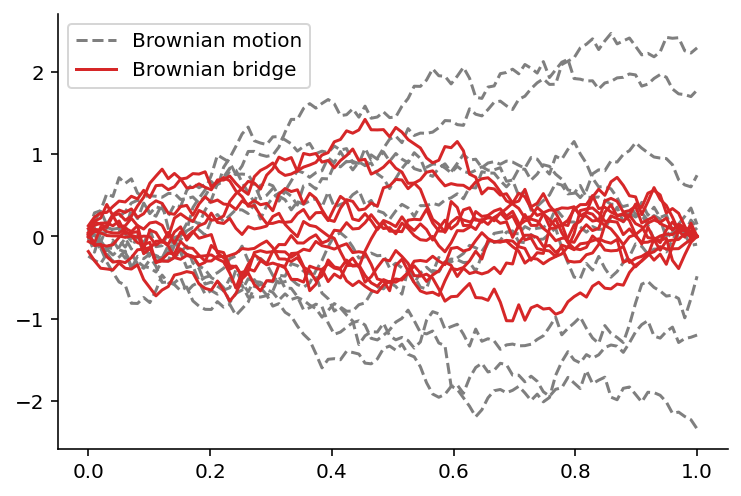

In [5]:
p1, *_ = plt.plot(timesteps, wt.T, c="tab:gray", linestyle="--", label="Brownian motion")
p2, *_ = plt.plot(timesteps, wb_t.T, c="tab:red", label="Brownian bridge")
ps = [p1, p2]
labels = [p.get_label() for p in ps]
plt.legend(ps, labels);

In [6]:
class AlphaMahalanobis:    
    def fit(self, X):
        K = jnp.cov(X.T)
        self.mean = X.mean(axis=1)
        self.eigvals, self.eigvecs = jnp.linalg.eigh(K)
    
    def smooth(self, X, alpha):
        coeffs = self.eigvals / (self.eigvals + alpha)
        X_alpha = jnp.einsum("j,...m,mj,kj->...k", coeffs, X, self.eigvecs, self.eigvecs)
        return X_alpha
    
    def distance(self, X, alpha):
        coeffs = self.eigvals / (self.eigvals + alpha) ** 2
        distance_val = jnp.einsum("j,...m,mj->...", coeffs, X, self.eigvecs)
        return distance_val

In [7]:
n_sims = 250
wt = sample_brownian_motion(key_bm, T, N, n_sims)
wb_t = sample_brownian_bridge(key_bb, T, N, n_sims)

In [8]:
metric_bm = AlphaMahalanobis()
metric_bm.fit(wt)
wt_alpha = metric_bm.smooth(wt, alpha=0.1)

metric_bb = AlphaMahalanobis()
metric_bb.fit(wb_t)
wb_t_alpha = metric_bb.smooth(wb_t, alpha=0.1)

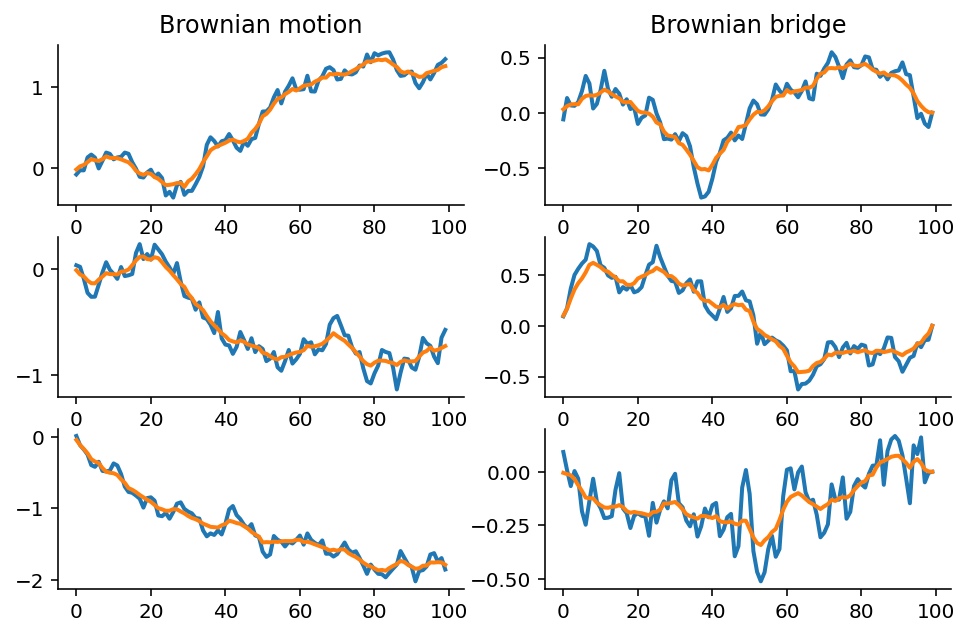

In [9]:
n_show = 3
indices = jax.random.choice(key, n_sims, (n_show,))

fig, ax = plt.subplots(3, 2, figsize=(8, 5))
for ax_row, ix in zip(ax, indices):
    ax0, ax1 = ax_row
    
    ax0.plot(wt[ix], linewidth=2)
    ax0.plot(wt_alpha[ix], linewidth=2)
    
    ax1.plot(wb_t[ix], linewidth=2)
    ax1.plot(wb_t_alpha[ix], linewidth=2)

ax[0,0].set_title("Brownian motion")
ax[0,1].set_title("Brownian bridge")

metric_bm = AlphaMahalanobis()
metric_bm.fit(wt)

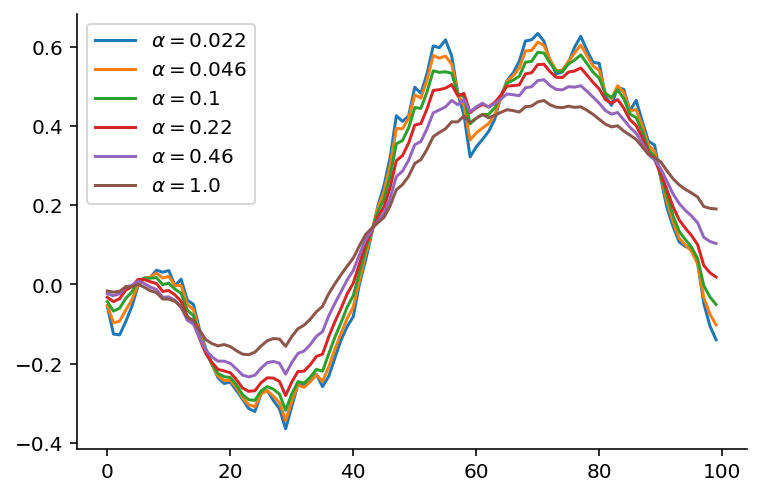

In [10]:
ix = 4
alphas = 10.0 ** (-jnp.arange(6) / 3)[::-1]
for alpha in alphas:
    wt_alpha = metric_bm.smooth(wt[ix], alpha=alpha)
    plt.plot(wt_alpha, label=rf"$\alpha={alpha:0.2}$")
    plt.legend()

## Testing the functional classificator

We consider a sample $x$ as class 1 if 

$$
    M^2_{\alpha, K_0}(x, m_0) - M^2_{\alpha, K_1}(x, m_1) > \log\left(\frac{\prod_{m=1}^M\lambda_m^{(1)}}{\prod_{m=1}^M\lambda_m^{(0)}}\right)
$$

## Bayes error

$$
    L^* = \frac{1}{2}  - \Phi\left(\frac{\sqrt{-(1 - T)\log(1 - T)}}{\sqrt{T (1 - T)}}\right) + \Phi\left(\frac{\sqrt{-(1 - T)\log(1 - T)}}{\sqrt{T}}\right)
$$

In [11]:
def bayes_error_bb_bm(T):
    t1 = jnp.sqrt(-(1 - T) * jnp.log(1 - T))
    return 1/2 - stats.norm.cdf(t1 / jnp.sqrt(T * (1 - T))) + stats.norm.cdf(t1 / jnp.sqrt(T))

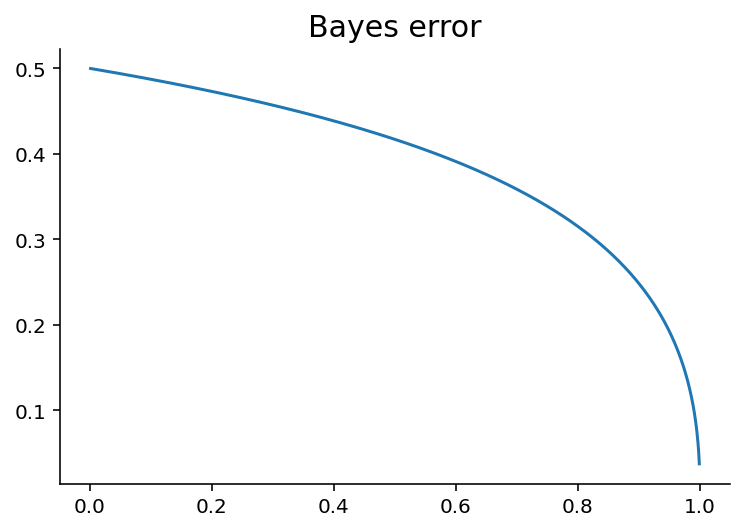

In [12]:
t_steps = jnp.linspace(0, 1, 1000)

bayes_err = bayes_error_bb_bm(t_steps)
plt.plot(t_steps, bayes_err)
plt.title("Bayes error", fontsize=15);

In [13]:
T = 1
n_steps = 49
timesteps = jnp.linspace(0, 1, n_steps)
cuts = jnp.array([0.75, 0.8125, 0.875, 0.9375, 1.0])

In [14]:
n_sims_train, n_sims_test = 50, 250
bmotion_train = sample_brownian_motion(key_bm, T, n_steps, n_sims_train + n_sims_test)
bbridge_train = sample_brownian_bridge(key_bb, T, n_steps, n_sims_train + n_sims_test)

bmotion_test = bmotion_train[n_sims_train:, :]
bbridge_test = bbridge_train[n_sims_train:, :]

bmotion_train = bmotion_train[:n_sims_train, :]
bbridge_train = bbridge_train[:n_sims_train, :]

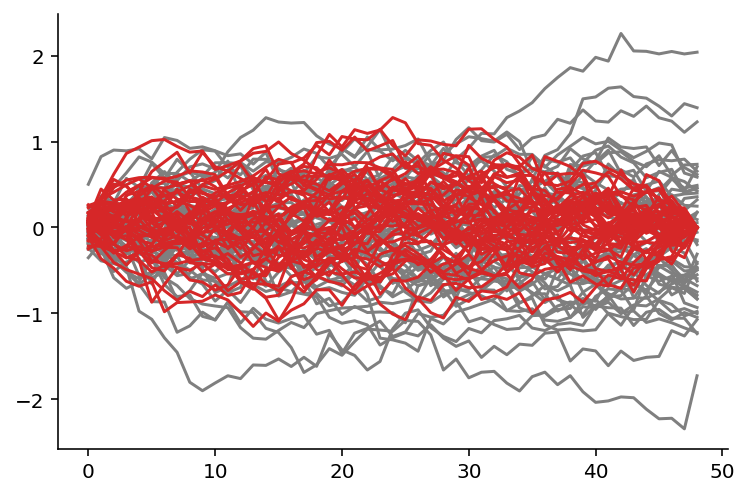

In [15]:
cut = cuts[-1]
plt.plot(bmotion_train[:, timesteps <= cut].T, c="tab:gray");
plt.plot(bbridge_train[:, timesteps <= cut].T, c="tab:red");

In [53]:
def classify_samples(metric0, metric1, samples, alpha):
    C = jnp.log(metric1.eigvals[:-11:-1].prod() / metric0.eigvals[:-11:-1].prod())
    yhat = metric0.distance(samples, alpha) ** 2 - metric1.distance(samples, alpha) ** 2 > C
    return yhat

In [54]:
cut = cuts[-1]
bm_cut_train = bmotion_train[:, timesteps <= cut]
bb_cut_train = bbridge_train[:, timesteps <= cut]

bm_cut_test = bmotion_test[:, timesteps <= cut]
bb_cut_test = bbridge_test[:, timesteps <= cut]

In [55]:
metric_bm = AlphaMahalanobis()
metric_bm.fit(bm_cut_train)

metric_bb = AlphaMahalanobis()
metric_bb.fit(bb_cut_train)

In [56]:
α = 0.1
test_set_x = jnp.r_[bb_cut_test, bm_cut_test]
test_set_y = jnp.r_[jnp.ones(n_sims_test), jnp.zeros(n_sims_test)]
(classify_samples(metric_bm, metric_bb, test_set_x, α) == test_set_y).mean()

DeviceArray(0.698, dtype=float32)

### Comparing multiple cuts

In [60]:
def test_alpha_mahalanobis(sample0, sample1, test_sample, test_labels, alpha):
    metric0 = AlphaMahalanobis()
    metric1 = AlphaMahalanobis()
    
    metric0.fit(sample0)
    metric1.fit(sample1)
    
    return (classify_samples(metric0, metric1, test_sample, alpha) == test_set_y).mean()

In [82]:
res = []

test_set_y = jnp.r_[jnp.ones(n_sims_test), jnp.zeros(n_sims_test)]

cuts = jnp.array([0.75, 0.8125, 0.875, 0.9375, 1.0])
# cuts = timesteps[-20:]
for cut in cuts:
    bm_cut_train = bmotion_train[:, timesteps <= cut]
    bb_cut_train = bbridge_train[:, timesteps <= cut]

    bm_cut_test = bmotion_test[:, timesteps <= cut]
    bb_cut_test = bbridge_test[:, timesteps <= cut]
    
    test_set_x = jnp.r_[bb_cut_test, bm_cut_test]
    accuracy = test_alpha_mahalanobis(bm_cut_train, bb_cut_train, test_set_x, test_set_y, α)
    
    res.append({
        "cut": cut.item(),
        "accuracy": accuracy.item()
    })

<AxesSubplot:xlabel='cut'>

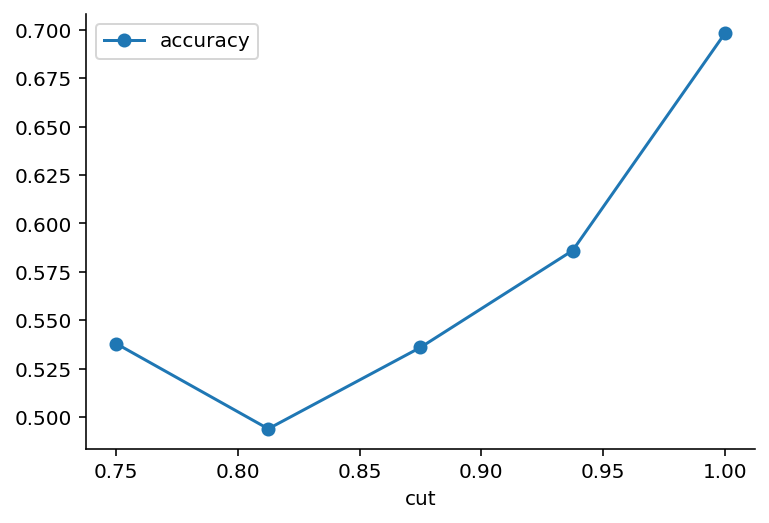

In [83]:
pd.DataFrame(res).set_index("cut").plot(marker="o")